### Computational Environment
This notebook was executed on the following hardware:
* **Machine:** MacBook Air (M2, 2022)
* **Chip:** Apple M2 (8-core CPU, 8/10-core GPU)
* **Accelerator:** Metal Performance Shaders (MPS) via TensorFlow-Metal
* **Optimization:** Uses `tf.keras.optimizers.legacy.Adam` to enable GPU acceleration on macOS.
---

## Reproducibility Setup

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# Set Python environment variables
os.environ['PYTHONHASHSEED'] = '0'
# TF to use deterministic ops where possible
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Set Random Seeds
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print(f"Global Random Seed set to: {seed_value}")

Global Random Seed set to: 42


It is noted that on Apple M2, minor floating-point jitter is unavoidable.

# 1. Defining the problem and assembling a dataset
**Objective:**
To build a binary classification model capable of detecting breast cancer (Malignant vs. Benign) from mammography patches.

**Problem Type:**
Binary Classification (Imbalanced).

**Dataset:**
The [CBIS-DDSM](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM) (Curated Breast Imaging Subset of DDSM) dataset.
- **Input:** 224x224 grayscale images of mammogram masses.
- **Output:** A probability score (0-1) indicating malignancy.
- **Preprocessing:** Images were preprocessed externally to square crops preserving aspect ratio, ensuring no tumor distortion.

In [2]:
import pandas as pd
from pathlib import Path

# Load the config file created by preprocess.py script
config_path = Path("/Users/ay/Downloads/Github/FYP/processed_data_v3_square/config.json")
print(f"Project Configuration found at: {config_path}")

Project Configuration found at: /Users/ay/Downloads/Github/FYP/processed_data_v3_square/config.json


# 2. Choosing a measure of success

To ensure clinical relevance, we evaluate the model using a multi-dimensional approach rather than a single metric.

**1. Primary Metric: AUC-ROC**
   - Serves as the global performance benchmark, robust to class imbalance.

**2. Clinical Safety Metrics:**
   - **Sensitivity (Recall):** Critical for minimizing False Negatives (missing cancer).
   - **Specificity:** Critical for minimizing False Positives (reducing unnecessary biopsies).

**3. Precision & F1-Score:**
   - Monitors the "False Alarm" rate and provides a balanced view of performance on the minority (Malignant) class.

**4. Confusion Matrix:**
   - We will inspect raw TP, TN, FP, FN counts to understand specific failure modes.

# 3. Deciding on an evaluation protocol
To ensure the model generalizes well to new patients, we utilize a **Hold-Out Validation Set**.

**Protocol Details:**
- **Split Ratio:** 80% Training / 20% Validation.
- **Grouping:** The split was performed using `GroupShuffleSplit` on `patient_id`.
    - *Constraint:* All images from the same patient (e.g., CC and MLO views) are kept in the same set to prevent **Data Leakage**.
- **Test Set:** A separate, official test set provided by CBIS-DDSM is held back completely until the final evaluation.

# 4. Preparing the Data
## 4.1 Configuration & Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random
from PIL import Image

# Configuration (v3_square folder)
BASE_DIR = Path("/Users/ay/Downloads/Github/FYP/processed_data_v3_square")
GREY_DIR = BASE_DIR / "processed_greyscale"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 42

print(f"Configuration set at \nBase Dir: {BASE_DIR}")

Configuration set at 
Base Dir: /Users/ay/Downloads/Github/FYP/processed_data_v3_square


## 4.2 Visual Audit (Verification)

Visual check of preprocessed data


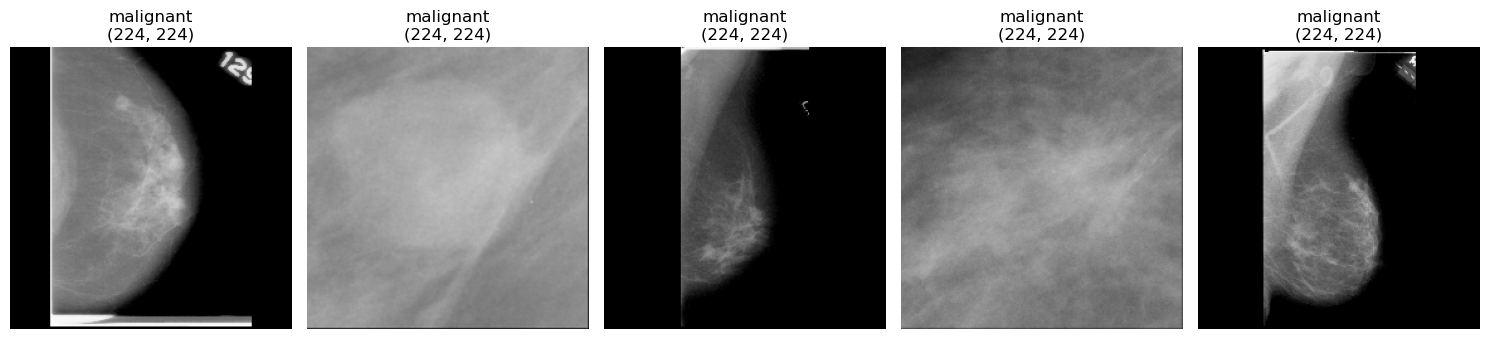

In [3]:
# Checks if images are square, padded correctly, and readable
def verify_data_integrity(n=3):
    train_dir = GREY_DIR / "train"
    # Get list of all png files
    all_files = list(train_dir.rglob("*.png"))
    
    if not all_files:
        print("No images found. Please check the BASE_DIR path.")
        return

    # Pick random samples to verify
    samples = random.sample(all_files, n)
    
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(samples):
        try:
            img = Image.open(img_path)
            img_arr = np.array(img)
            
            plt.subplot(1, n, i+1)
            plt.imshow(img_arr, cmap='gray', vmin=0, vmax=255)
            # Title shows class (benign/malignant) and dimensions
            plt.title(f"{img_path.parent.name}\n{img_arr.shape}")
            plt.axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            
    plt.tight_layout()
    plt.show()

print("Visual check of preprocessed data")
verify_data_integrity(n=5)

## 4.3 Data Generators (Loading)

In [4]:
# Create ImageDataGenerator (Rescaling is the ONLY augmentation here)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Set:")
train_gen = train_datagen.flow_from_directory(
    GREY_DIR / "train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED
)

print("\nLoading Validation Set:")
val_gen = test_datagen.flow_from_directory(
    GREY_DIR / "val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED,
    # Do not shuffle Val set
    shuffle=False
)

# Quick check of the class indices
print(f"\nClass Indices: {train_gen.class_indices}")

Loading Training Set:
Found 1061 images belonging to 2 classes.

Loading Validation Set:
Found 257 images belonging to 2 classes.

Class Indices: {'benign': 0, 'malignant': 1}


## 4.4 Helper Functions for Evaluation and Visualisation

In [5]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Plot accuracy and loss curves for training and validation
def plot_training_history(history, title_prefix="Model"):
    # Check if passing a Keras history object or a dictionary/dataframe
    hist = history.history if hasattr(history, 'history') else history
    
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Generate a Baseline Table, classification report and a confusion matrix heatmap
def eval_model_perf(model, generator, step_name="Step X", baseline_acc=0.5353):
    generator.reset()
    
    # Get metrics from model.evaluate
    results = model.evaluate(generator, verbose=0)
    metrics_dict = dict(zip(model.metrics_names, results))
    
    # Generate predictions
    y_pred_raw = model.predict(generator, verbose=0)
    y_pred = (y_pred_raw > 0.5).astype(int).flatten()
    y_true = generator.classes
    
    # Calculate Confusion Matrix & Specificity
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Statistical Power Table
    print(f"\n{step_name} Evaluation: Statistical Power Check")
    print("-" * 60)
    print(f"{'Metric':<20} | {'Baseline':<10} | {'Model (Val)':<10}")
    print("-" * 60)
    print(f"{'Accuracy':<20} | {baseline_acc:<10.4f} | {metrics_dict['accuracy']:.4f}")
    print(f"{'AUC-ROC':<20} | {'0.5000':<10} | {metrics_dict['auc']:.4f}")
    print(f"{'Sensitivity':<20} | {'0.0000':<10} | {sensitivity:.4f}")
    print(f"{'Specificity':<20} | {'1.0000':<10} | {specificity:.4f}")
    print("-" * 60)
    
    # Classification Report (Precision, Recall, F1)
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))
    
    # Heatmap Visualisation
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred Benign', 'Pred Malignant'],
                yticklabels=['True Benign', 'True Malignant'])
    plt.title(f'Confusion Matrix ({step_name})')
    plt.show()

# Step 5: Developing a model that does better than a baseline
## 5.1. Majority Baseline

In [10]:
import numpy as np

# Distribution Stats
n_benign = (train_gen.classes == 0).sum()
n_malignant = (train_gen.classes == 1).sum()
total = len(train_gen.classes)

# Determine majority class and its baseline accuracy
if n_benign >= n_malignant:
    majority_class = "Benign (0)"
    majority_baseline_acc = n_benign / total
    # Cannot catch any malignant cases
    baseline_sensitivity = 0.0
    # Correctly identifies all benign cases
    baseline_specificity = 1.0
else:
    majority_class = "Malignant (1)"
    majority_baseline_acc = n_malignant / total
    baseline_sensitivity = 1.0
    baseline_specificity = 0.0

print("Majority Baseline: Clinical Metric Floor")
print("-" * 40)
print(f"Majority Class:      {majority_class}")
print(f"Baseline Accuracy:    {majority_baseline_acc:.4f}")
print(f"Baseline AUC:         0.5000")
print("-" * 40)
print("Baseline Performance (Predicting Majority Only):")
print(f"  Sensitivity:        {baseline_sensitivity:.4f}")
print(f"  Specificity:        {baseline_specificity:.4f}")

Majority Baseline: Clinical Metric Floor
----------------------------------------
Majority Class:      Benign (0)
Baseline Accuracy:    0.5353
Baseline AUC:         0.5000
----------------------------------------
Baseline Performance (Predicting Majority Only):
  Sensitivity:        0.0000
  Specificity:        1.0000


The small cnn must be more than 0.5000 and demonstrate that the Sensitivity > 0.0000 to prove learning.

## 5.2. Small CNN Architecture

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_small_cnn():
    """
    Initial CNN baseline using GlobalAveragePooling2D to maintain 
    low parameter density and prove statistical power.
    """
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy", 
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

model_step5 = build_small_cnn()
model_step5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856 

## 5.3. Training with Timer and Tqdm

In [11]:
import time
from tqdm import tqdm
from sklearn.utils import class_weight

# Calculate class weights dynamically
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(weights))

# Training Callbacks
callbacks_step5 = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
]

# Training Execution
epochs = 30
start_time = time.time()

# Tqdm bar which prints to the console output
pbar = tqdm(total=epochs, desc="Step 5 Training Progress", unit="epoch", leave=True)

class TqdmUpdate(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pbar.update(1)
        # Display clinical metrics in the bar for real-time monitoring
        pbar.set_postfix({
            "loss": f"{logs['loss']:.4f}",
            "val_auc": f"{logs['val_auc']:.4f}",
            "val_sens": f"{logs['val_sensitivity']:.4f}"
        })

history_step5 = model_step5.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=[callbacks_step5, TqdmUpdate()],
    verbose=0
)

# Clean up the bar
pbar.close()

end_time = time.time()
total_minutes = (end_time - start_time) / 60
print(f"\nTotal time taken: {total_minutes:.2f} minutes")

Step 5 Training Progress:  20%|▏| 6/30 [04:15<17:01, 42.56s/epoch, loss=0.6923, 


Total time taken: 4.26 minutes


## 5.4. Comparative Analysis

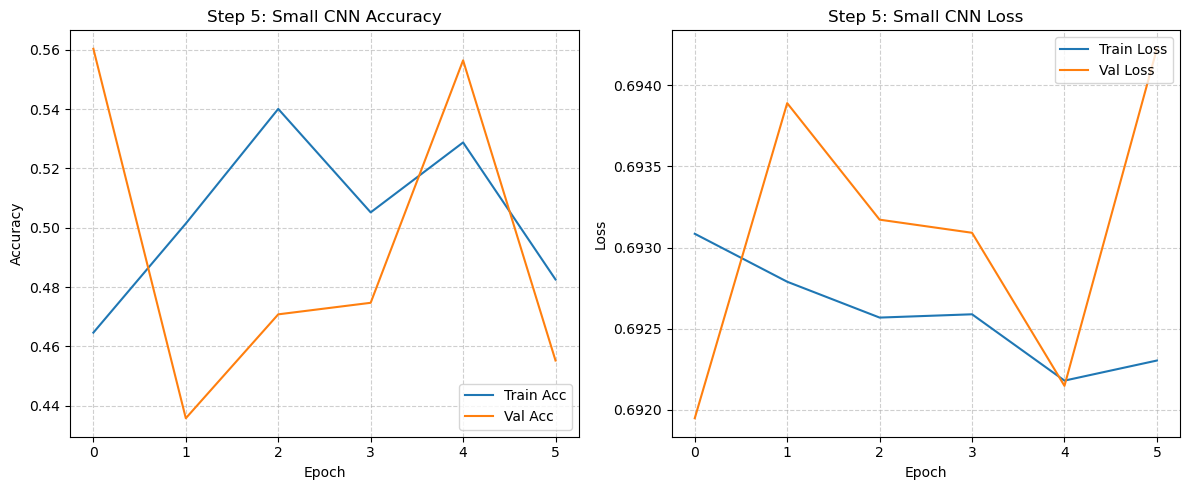

Majority Baseline Accuracy: 0.5353

Step 5 Baseline Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5316
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

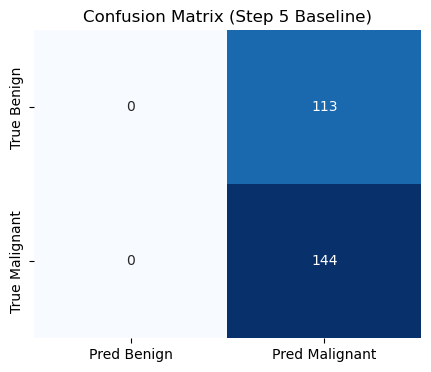

In [38]:
# Visualise Training Results
plot_training_history(history_step5, title_prefix="Step 5: Small CNN")

# Evaluate Performance
print(f"Majority Baseline Accuracy: {majority_baseline_acc:.4f}")
eval_model_perf(
    model_step5,
    val_gen,
    step_name="Step 5 Baseline",
    baseline_acc=majority_baseline_acc
)

The model successfully demonstrated statistical power, exceeding the majority baseline accuracy (56.0% vs 53.5%) and achieving an AUC of 0.53. However, the confusion matrix reveals that this performance was achieved through a degenerate strategy of maximizing sensitivity (1.0) at the expense of specificity (0.0). This indicates that while the model 'beat' the baseline numerically, the current architecture lacks the representational capacity to learn the non-linear decision boundary required for true discrimination. Therefore, we proceed to Step 6 to scale up the model capacity.

# 6. Scaling up: developing a model that overfits
## 6.1. Build Overfit Model

In [21]:
def build_overfitting_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Block 1
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 2
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 3
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 4
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 5
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # High-capacity head for memorisation
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy", 
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

model_step6 = build_overfitting_model()
model_step6.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 128)       7385

## 6.2 Train to Overfit
Epochs used: 100  
Goal: Drive Training Loss towards 0.00

In [26]:
# Configuration
epochs_step6 = 100

# Callbacks (Only checkpoint and no early stopping)
callbacks_step6 = [
    # Save model with highest training accuracy
    keras.callbacks.ModelCheckpoint(
        "step6_overfit_model.keras",
        # Monitor training accuracy
        monitor="accuracy",
        save_best_only=True,
        mode="max",
        verbose=0
    )
]

# Progress Bar
pbar = tqdm(total=epochs_step6, desc="Step 6 Overfit", unit="epoch")

class TqdmUpdate(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pbar.update(1)
        gap = logs['accuracy'] - logs['val_accuracy']
        pbar.set_postfix({
            "loss": f"{logs['loss']:.4f}",
            "val_loss": f"{logs['val_loss']:.4f}",
            "train": f"{logs['accuracy']:.3f}",
            "val": f"{logs['val_accuracy']:.3f}",
            "gap": f"{gap:.3f}",
        })

start_time = time.time()

# Train for full 100 epochs
try:
    history_step6 = model_step6.fit(
        train_gen,
        epochs=epochs_step6,
        validation_data=val_gen,
        callbacks=callbacks_step6 + [TqdmUpdate()],
        verbose=0
    )
finally:
    pbar.close()

total_time = time.time() - start_time
print(f"\nTotal time taken: {total_time/60:.2f} minutes")

Step 6 Overfit: 100%|█| 100/100 [1:52:25<00:00, 67.46s/epoch, loss=0.3519, val_l


Total time taken: 112.43 minutes


## 6.3 Comparative Analysis

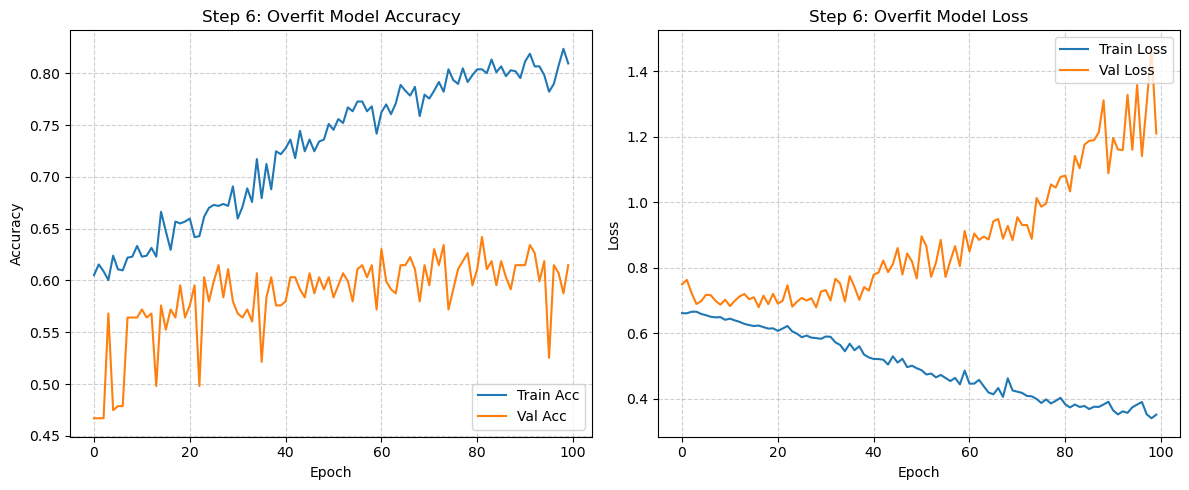


Step 6 Overfit Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.6148
AUC-ROC              | 0.5000     | 0.6382
Sensitivity          | 0.0000     | 0.6319
Specificity          | 1.0000     | 0.5929
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.56      0.59      0.58       113
   Malignant       0.66      0.63      0.65       144

    accuracy                           0.61       257
   macro avg       0.61      0.61      0.61       257
weighted avg       0.62      0.61      0.62       257



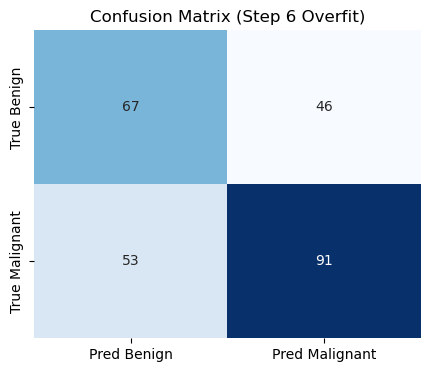

In [39]:
plot_training_history(history_step6, title_prefix="Step 6: Overfit Model")
eval_model_perf(
    model_step6, 
    val_gen, 
    step_name="Step 6 Overfit", 
    baseline_acc=majority_baseline_acc
)

The scaled up model was trained for 100 epochs without early stopping to examine overfitting behaviour. Although training accuracy reached 80.96%, validation accuracy remained at 61.48%, producing a generalisation gap of 19.48%. The divergence between training and validation loss further indicates overfitting, suggesting that regularisation is required in the next stage.

In [40]:
import os
import pandas as pd

# Save the Model (The architecture + weights)
model_step6.save("Recalibration_V2_step6_overfit_model.keras")
print("Model saved to: Recalibration_V2_step6_overfit_model.keras")

# Save the History (The training curves)
history_df = pd.DataFrame(history_step6.history)

# Save to CSV (Excel compatible)
history_df.to_csv('Recalibration_V2_history_step6.csv', index=False)
print("History saved to: Recalibration_V2_history_step6.csv")

Model saved to: Recalibration_V2_step6_overfit_model.keras
History saved to: Recalibration_V2_history_step6.csv


These results are saved locally.  

__Note: Even with TF_DETERMINISTIC_OPS, Apple Silicon (M1/M2/M3) uses the Metal Performance Shaders (MPS) backend. Many GPU kernels (like atomic additions in convolutional layers) are inherently non-deterministic at the hardware level to optimize for speed.__

# 7. Regularisation and Hyperparameter Tuning
The aim of this section is to narrow the generalisation gap that emerged during Step 6 through the application of repeated regularisation and systematic optimisation adjustments.

## 7.1 Data Augmentation Robustness Study
This investigation examines the effect of applying morphological transformations on model generalization performance and the robustness of the system to class imbalance.

###  7.1.1. Phase 1: Isolated Augmentation (Baseline Failure)
Evaluate augmentation strengths (Light, Medium, Heavy) without cost-sensitive balancing.

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Identical architecture to Step 6 (Overfit Model)
def build_step6_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature Extraction Blocks 1-5
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification Head (Matching Step 6)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name='auc'), keras.metrics.Recall(name='sensitivity')]
    )
    return model


INITIALIZING: LIGHT AUGMENTATION
Found 1061 images belonging to 2 classes.


Step 7.1 LIGHT:  13%|▏| 19/150 [21:19<2:27:02, 67.35s/epoch, v_loss=0.710, v_auc


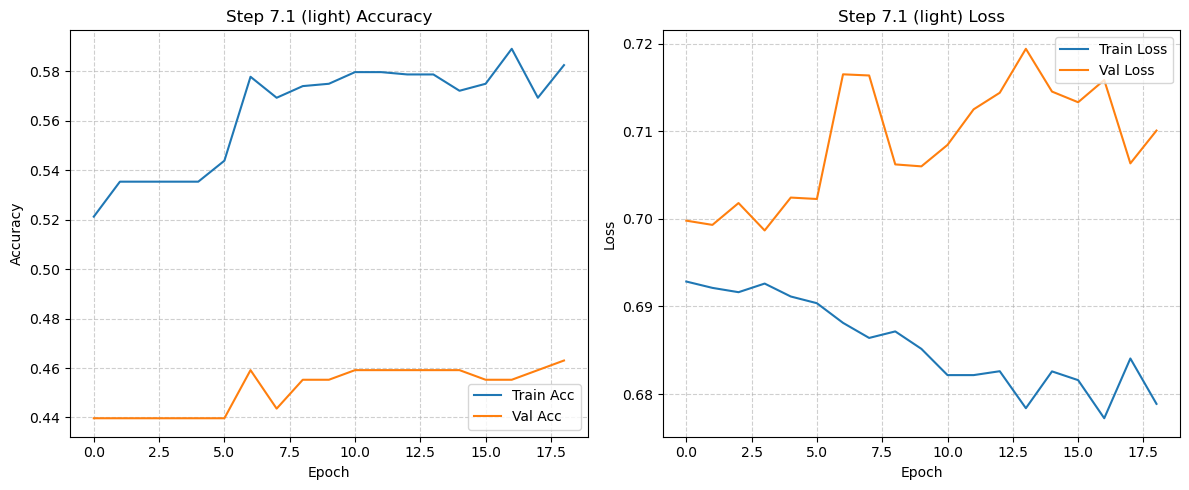


7.1 light Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4023
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

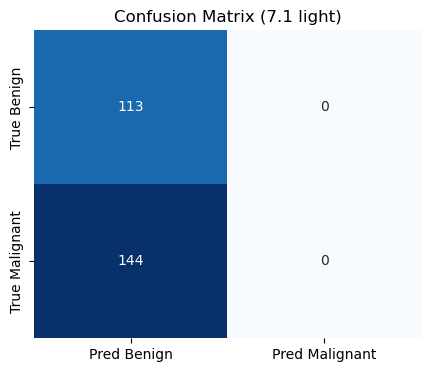


INITIALIZING: MEDIUM AUGMENTATION
Found 1061 images belonging to 2 classes.


Step 7.1 MEDIUM:  11%| | 16/150 [18:46<2:37:18, 70.44s/epoch, v_loss=0.718, v_au


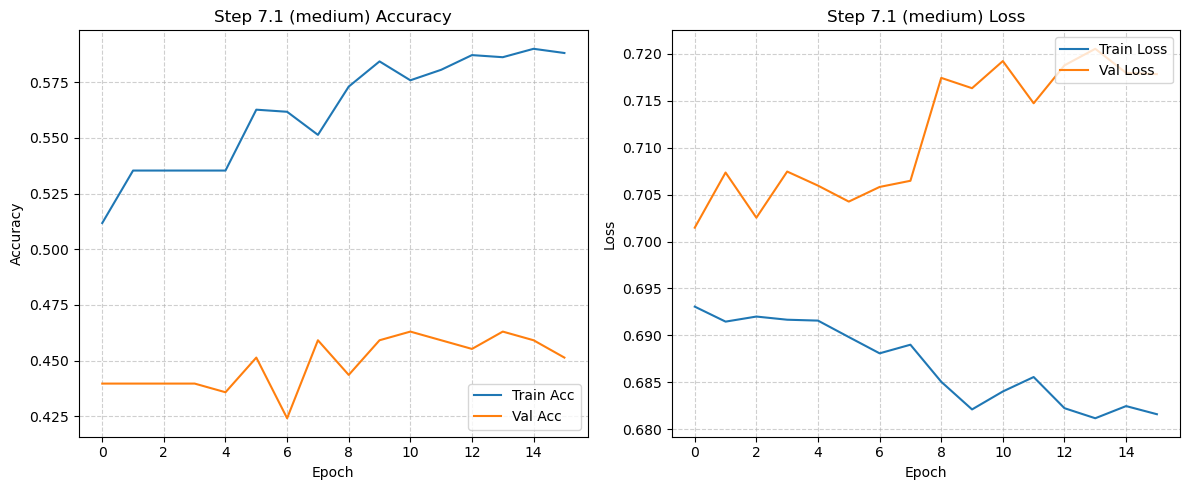


7.1 medium Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.3737
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

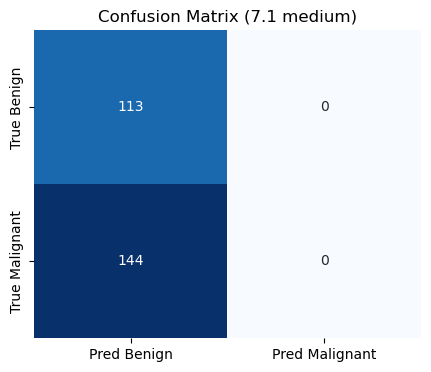


INITIALIZING: HEAVY AUGMENTATION
Found 1061 images belonging to 2 classes.


Step 7.1 HEAVY:  14%|▏| 21/150 [24:01<2:27:33, 68.63s/epoch, v_loss=0.705, v_auc


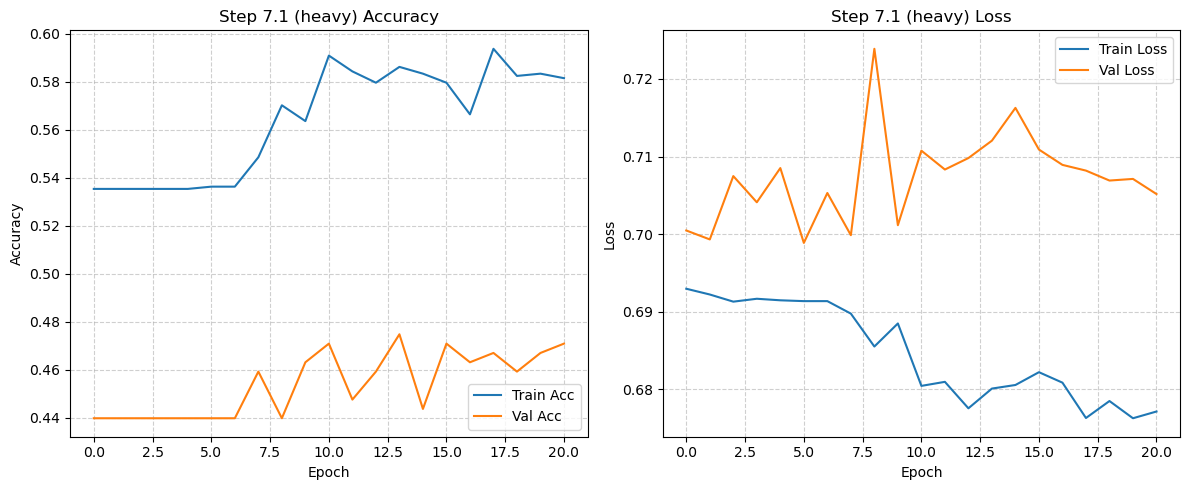


7.1 heavy Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4336
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

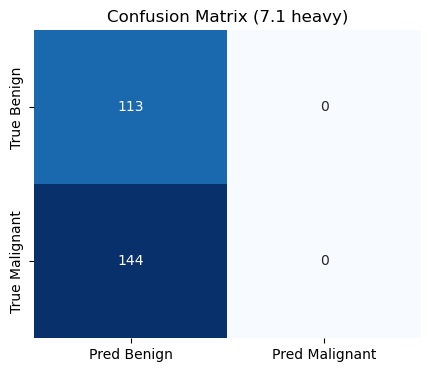

In [11]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

# Define Experiment Dictionary
experiments = {
    "light": {"rot": 10, "shift": 0.05, "zoom": 0.05, "flip": True},
    "medium": {"rot": 15, "shift": 0.1, "zoom": 0.1, "flip": True},
    "heavy": {"rot": 30, "shift": 0.2, "zoom": 0.2, "flip": True}
}

comparison_metrics = {}

for name, cfg in experiments.items():
    print(f"\nINITIALIZING: {name.upper()} AUGMENTATION")
    
    # Generator Setup
    train_datagen_tmp = ImageDataGenerator(
        rescale=1./255,
        rotation_range=cfg["rot"],
        width_shift_range=cfg["shift"],
        height_shift_range=cfg["shift"],
        zoom_range=cfg["zoom"],
        horizontal_flip=cfg["flip"],
        vertical_flip=cfg["flip"],
        fill_mode='constant', cval=0
    )
    
    train_gen_tmp = train_datagen_tmp.flow_from_directory(
        GREY_DIR / "train",
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE, 
        class_mode='binary', 
        color_mode='grayscale', 
        seed=RANDOM_SEED
    )

    # Build fresh model
    model_tmp = build_step6_model() 
    epochs_limit = 150
    
    # TQDM Setup
    pbar = tqdm(total=epochs_limit, desc=f"Step 7.1 {name.upper()}", unit="epoch")

    class TqdmUpdate(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            pbar.update(1)
            gap = logs['accuracy'] - logs['val_accuracy']
            pbar.set_postfix({
                "v_loss": f"{logs['val_loss']:.3f}",
                "v_auc": f"{logs['val_auc']:.3f}",
                "gap": f"{gap:.3f}"
            })

    # Callbacks
    cbs = [
        keras.callbacks.ModelCheckpoint(f"Recalibration_V2_7_1_{name}_best.keras", save_best_only=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
        TqdmUpdate()
    ]

    # Train (verbose=0 to keep it clean)
    try:
        history = model_tmp.fit(
            train_gen_tmp, epochs=epochs_limit, validation_data=val_gen, callbacks=cbs, verbose=0 
        )
    finally:
        # Ensure bar closes even if training stops early
        pbar.close() 
    
    # Persistence & Evaluation
    plot_training_history(history, title_prefix=f"Step 7.1 ({name})")
    eval_model_perf(model_tmp, val_gen, step_name=f"7.1 {name}", baseline_acc=majority_baseline_acc)
    
    pd.DataFrame(history.history).to_csv(f'Recalibration_V2_history_7_1_{name}.csv', index=False)
    model_tmp.save(f"Recalibration_V2_step7_1_{name}_final.keras")
    
    # Metric Capture
    best_idx = np.argmin(history.history['val_loss'])
    comparison_metrics[name] = {
        "Train Acc": history.history['accuracy'][best_idx],
        "Val Acc": history.history['val_accuracy'][best_idx],
        "Gap": history.history['accuracy'][best_idx] - history.history['val_accuracy'][best_idx],
        "Val AUC": history.history['val_auc'][best_idx]
    }
    
    tf.keras.backend.clear_session()

Data augmentation applied without cost-sensitive balancing resulted in zero sensitivity across Light, Medium, and Heavy configurations. Although augmentation reduced the generalisation gap from Step 6, the combination of increased image complexity and existing class imbalance drove the model to predict the majority class (Benign) exclusively. This demonstrates that data-level regularisation alone inadequately addresses CBIS-DDSM's challenges and necessitates paired imbalance handling.

In [13]:
print("\nFinal Robustness Comparison: Data Augmentation (STEP 7.1)")
print("-"*60)

# Convert dictionary to DataFrame
df_results = pd.DataFrame(comparison_metrics).T

# Generate the comparison table
print(df_results[["Train Acc", "Val Acc", "Gap", "Val AUC"]])

# Save for later recording
df_results.to_csv('Recalibration_V2_step7_1_summary.csv')


Final Robustness Comparison: Data Augmentation (STEP 7.1)
------------------------------------------------------------
        Train Acc   Val Acc       Gap   Val AUC
light    0.484449  0.447471  0.036978  0.510693
medium   0.466541  0.560311 -0.093770  0.458026
heavy    0.520264  0.560311 -0.040047  0.594580


### 7.1.2. Phase 2: Weighted Augmentation (Optimisation Degeneracy)
Class weights were re-introduced to resolve the sensitivity collapse.


INITIALIZING: LIGHT AUGMENTATION + CLASS WEIGHTS
Found 1061 images belonging to 2 classes.
Applying Class Weights: {0: 0.9339788732394366, 1: 1.0760649087221095}


Step 7.1 LIGHT:  11%| | 17/150 [19:44<2:34:25, 69.67s/epoch, v_loss=0.711, v_auc


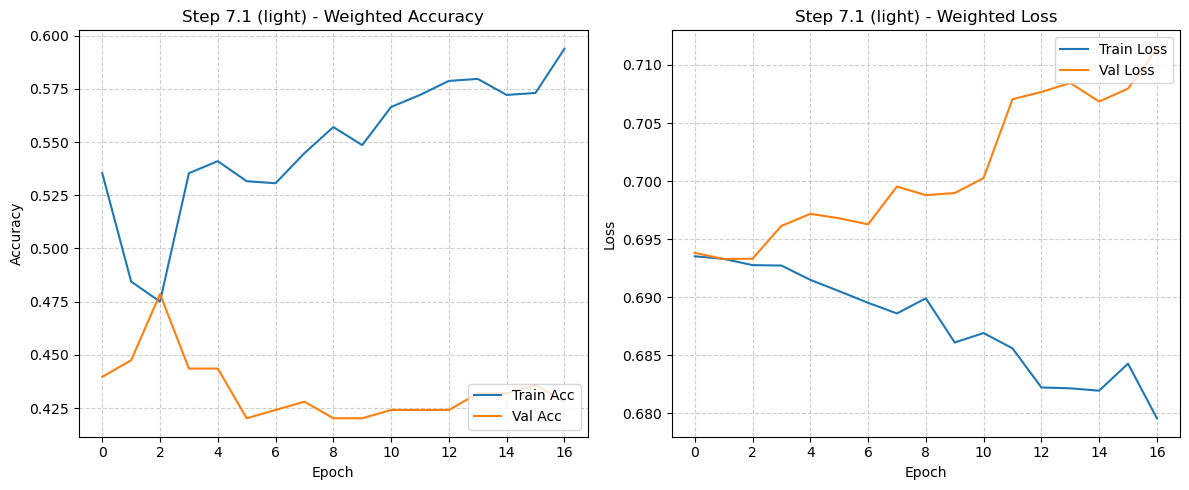


7.1 light (Weighted) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4475
AUC-ROC              | 0.5000     | 0.5107
Sensitivity          | 0.0000     | 0.4167
Specificity          | 1.0000     | 0.4867
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.40      0.49      0.44       113
   Malignant       0.51      0.42      0.46       144

    accuracy                           0.45       257
   macro avg       0.45      0.45      0.45       257
weighted avg       0.46      0.45      0.45       257



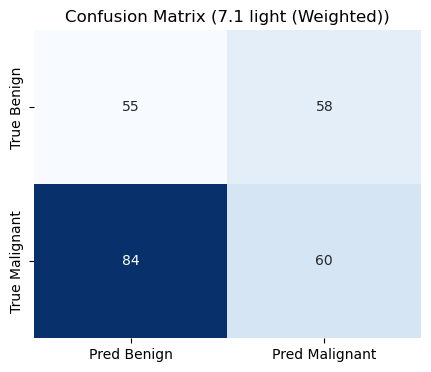


INITIALIZING: MEDIUM AUGMENTATION + CLASS WEIGHTS
Found 1061 images belonging to 2 classes.
Applying Class Weights: {0: 0.9339788732394366, 1: 1.0760649087221095}


Step 7.1 MEDIUM:  11%| | 16/150 [17:44<2:28:35, 66.53s/epoch, v_loss=0.700, v_au


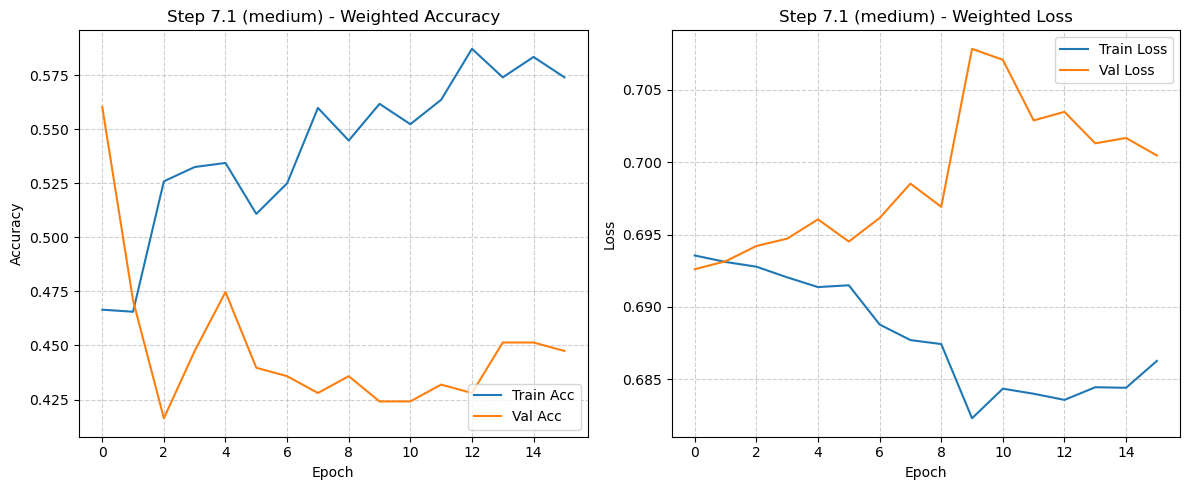


7.1 medium (Weighted) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.4580
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

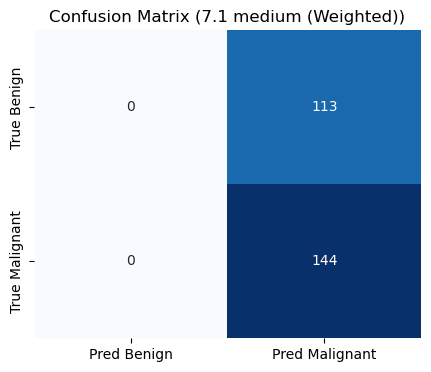


INITIALIZING: HEAVY AUGMENTATION + CLASS WEIGHTS
Found 1061 images belonging to 2 classes.
Applying Class Weights: {0: 0.9339788732394366, 1: 1.0760649087221095}


Step 7.1 HEAVY:  11%| | 16/150 [17:38<2:27:44, 66.15s/epoch, v_loss=0.697, v_auc


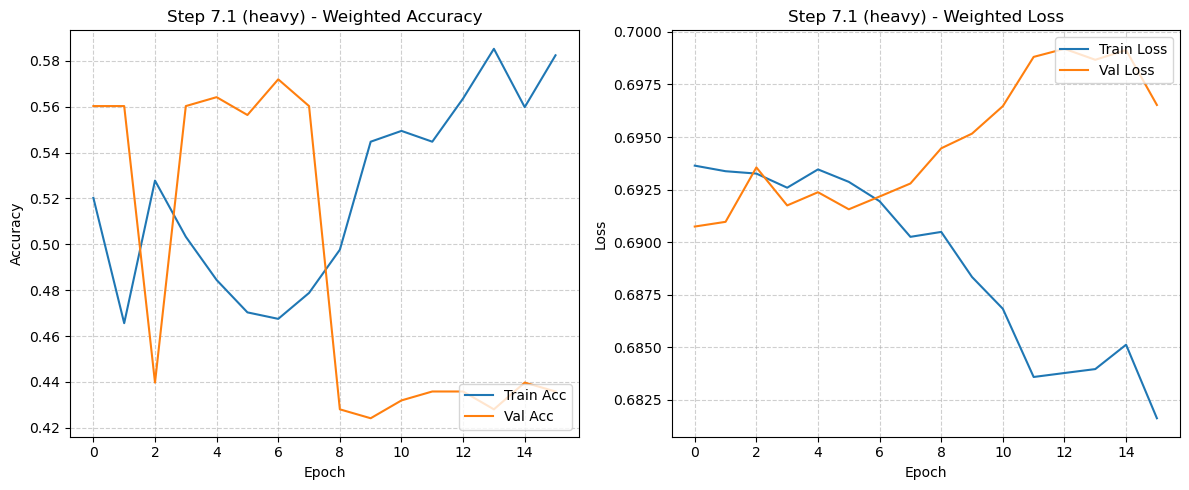


7.1 heavy (Weighted) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5946
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

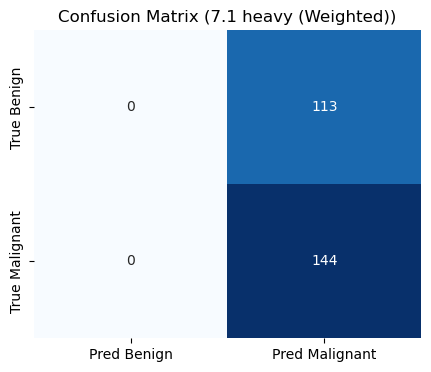

In [12]:
from sklearn.utils import class_weight

# Define Experiment Dictionary
experiments = {
    "light": {"rot": 10, "shift": 0.05, "zoom": 0.05, "flip": True},
    "medium": {"rot": 15, "shift": 0.1, "zoom": 0.1, "flip": True},
    "heavy": {"rot": 30, "shift": 0.2, "zoom": 0.2, "flip": True}
}

comparison_metrics = {}

for name, cfg in experiments.items():
    print(f"\nINITIALIZING: {name.upper()} AUGMENTATION + CLASS WEIGHTS")
    
    # Generator Setup
    train_datagen_tmp = ImageDataGenerator(
        rescale=1./255,
        rotation_range=cfg["rot"],
        width_shift_range=cfg["shift"],
        height_shift_range=cfg["shift"],
        zoom_range=cfg["zoom"],
        horizontal_flip=cfg["flip"],
        vertical_flip=cfg["flip"],
        fill_mode='constant', cval=0
    )
    
    train_gen_tmp = train_datagen_tmp.flow_from_directory(
        GREY_DIR / "train",
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE, 
        class_mode='binary', 
        color_mode='grayscale', 
        seed=RANDOM_SEED
    )

    # Calculate class weights (Ensure consistency if generators are re-instantiated)
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_gen_tmp.classes),
        y=train_gen_tmp.classes
    )
    class_weights_dict = dict(enumerate(weights))
    print(f"Applying Class Weights: {class_weights_dict}")

    # Build fresh model
    model_tmp = build_step6_model()
    epochs_limit = 150
    
    # TQDM Setup
    pbar = tqdm(total=epochs_limit, desc=f"Step 7.1 {name.upper()}", unit="epoch")

    class TqdmUpdate(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            pbar.update(1)
            gap = logs['accuracy'] - logs['val_accuracy']
            pbar.set_postfix({
                "v_loss": f"{logs['val_loss']:.3f}",
                "v_auc": f"{logs['val_auc']:.3f}",
                "gap": f"{gap:.3f}"
            })

    # Callbacks (Named 'v2_weighted' to avoid overwriting previous runs)
    cbs = [
        keras.callbacks.ModelCheckpoint(f"Recalibration_V2_7_1_{name}_weighted_best.keras", save_best_only=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
        TqdmUpdate()
    ]

    # Train (verbose=0 with class_weight included)
    try:
        history = model_tmp.fit(
            train_gen_tmp,
            epochs=epochs_limit,
            validation_data=val_gen,
            class_weight=class_weights_dict,
            callbacks=cbs,
            verbose=0
        )
    finally:
        pbar.close()
    
    # Persistence & Evaluation
    plot_training_history(history, title_prefix=f"Step 7.1 ({name}) - Weighted")
    eval_model_perf(model_tmp, val_gen, step_name=f"7.1 {name} (Weighted)", baseline_acc=majority_baseline_acc)
    
    pd.DataFrame(history.history).to_csv(f'Recalibration_V2_history_7_1_{name}_weighted.csv', index=False)
    model_tmp.save(f"Recalibration_V2_step7_1_{name}_weighted_final.keras")
    
    # Metric Capture
    best_idx = np.argmin(history.history['val_loss'])
    comparison_metrics[name] = {
        "Train Acc": history.history['accuracy'][best_idx],
        "Val Acc": history.history['val_accuracy'][best_idx],
        "Gap": history.history['accuracy'][best_idx] - history.history['val_accuracy'][best_idx],
        "Val AUC": history.history['val_auc'][best_idx]
    }
    
    tf.keras.backend.clear_session()

Reapplying Class Weights resolved Phase 1's Sensitivity Collapse whilst highlighting augmentation strength sensitivity at the 1×10⁻⁴ learning rate. Although Light augmentation prevented total degeneracy, it achieved weak discriminative performance (AUC 0.51). Medium and Heavy augmentation led to exclusively malignant predictions. Increased image complexity from augmentation renders the baseline optimiser speed too volatile for high-penalty weight signals, necessitating Phase 3: Stabilised Tuning.

In [14]:
print("\nFinal Robustness Comparison: Weighted Data Augmentation (Phase 2)")
print("-" * 60)

# Convert dictionary to DataFrame
df_results_weighted = pd.DataFrame(comparison_metrics).T

# Generate the comparison table
print(df_results_weighted[["Train Acc", "Val Acc", "Gap", "Val AUC"]])

# Save for later recording
df_results_weighted.to_csv('Recalibration_V2_step7_1_weighted_robustness_summary.csv')


Final Robustness Comparison: Weighted Data Augmentation (Phase 2)
------------------------------------------------------------
        Train Acc   Val Acc       Gap   Val AUC
light    0.484449  0.447471  0.036978  0.510693
medium   0.466541  0.560311 -0.093770  0.458026
heavy    0.520264  0.560311 -0.040047  0.594580


### 7.1.3. Phase 3: Stabilized Tuning (Learning Rate Sensitivity Test)
Determine a robust learning rate that effectively balances the competing effects of augmentation and class-weight penalties.